In [2]:

import tensorflow as tf
import segmentation_models as sm
import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.metrics import MeanIoU
import time
import pickle
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score



Segmentation Models: using `keras` framework.


In [3]:
x_train= pickle.load(open("Datasets/aug_with_masks/X_train.pickle","rb"))
y_train = pickle.load(open("Datasets/aug_with_masks/y_train.pickle","rb"))
x_val = pickle.load(open("Datasets/aug_with_masks/X_test.pickle","rb"))
y_val = pickle.load(open("Datasets/aug_with_masks/y_test.pickle","rb"))

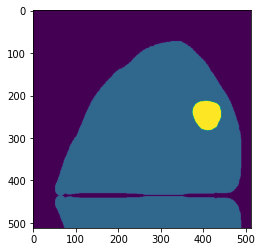

In [9]:
labels = np.expand_dims(y_train, axis=3)
plt.imshow(labels[5][:,:,0])
plt.show()
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [4]:
from tensorflow.keras.utils import to_categorical
n_classes = len(np.unique(y_train))
labels_train = np.expand_dims(y_train, axis=3)
labels_test = np.expand_dims(y_val, axis=3)
n_classes = len(np.unique(y_train))
train_masks_cat = to_categorical(labels_train, num_classes=n_classes)
# y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(labels_test, num_classes=n_classes)


# y_test_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [4]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)
sm.set_framework('tf.keras')
# preprocess input
x_train = preprocess_input(x_train)
x_val = preprocess_input(x_val)

# define model
model = sm.Unet(BACKBONE, classes=n_classes, encoder_weights='imagenet',activation='softmax')
model.compile(optimizer='adam', loss=bce_jaccard_loss, metrics=['accuracy',iou_score])

print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 3 9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, None, None, 3 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 9408        zero_padding2d[0][0]             
____________________________________________________________________________________________

In [5]:
history=model.fit(x_train,
          train_masks_cat,
          batch_size=4,
          epochs=50,
          verbose=1,
          validation_data=(x_val, test_masks_cat))


Epoch 1/50
200/200 [==============================] - 76s 322ms/step - loss: 0.7567 - accuracy: 0.9119 - iou_score: 0.4062 - val_loss: 1.3833 - val_accuracy: 0.5974 - val_iou_score: 0.1512

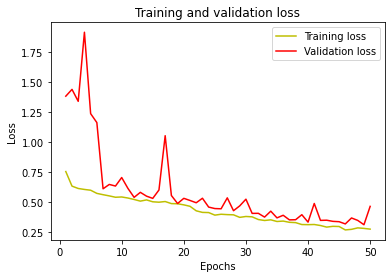

In [6]:
accuracy = model.evaluate(x_val, y_val)
print(accuracy)
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [7]:
NAME = f"{BACKBONE}-usingIOU-{format(int(time.time()))}"
model.save(f'{NAME}.h5')

c:\users\moham\desktop\mydeeplearningproject\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [5]:
from tensorflow import keras
model = keras.models.load_model('resnet34-usingIOU-1632716594.h5', compile=False)
preprocess_input=sm.get_preprocessing('resnet34')
# model = keras.models.load_model('resnet34-1632495563.h5', compile=False)

Ground Truth labels-[0 1 2 3]
Predicted labels-[0 1 3]


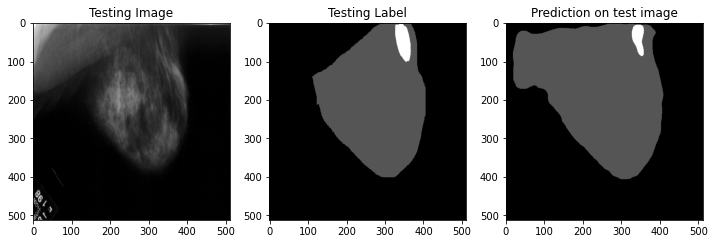

In [20]:
import random
# get a random image from validation set
test_img_number = random.randint(0, len(x_val))
test_img = x_val[test_img_number]
ground_truth=y_val[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
testlabels=np.unique(ground_truth)
print(f'Ground Truth labels-{testlabels}')
test_img_input=np.expand_dims(test_img,0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]
predlabels=np.unique(predicted_img)
print(f'Predicted labels-{predlabels}')
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth, cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='gray')
plt.show()

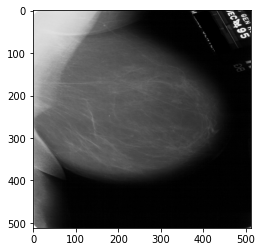

[6.5935295e-16 6.6965197e-16 6.8029605e-16 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0 1]


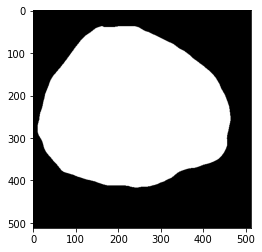

In [29]:
#Test on a different image
#READ EXTERNAL IMAGE...

test_img = cv2.imread('C:/Users/moham/Desktop/breast cancer dataset/Images/Cancer/A_1619_1.RIGHT_MLO.png')
test_img = cv2.resize(test_img, (512, 512))
plt.imshow(test_img)
plt.show()
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img_inp = np.expand_dims(test_img,0)
test_img_inp=test_img_inp/255.
# test_img_inp = preprocess_input(test_img_inp)
prediction = model.predict(test_img_inp)
predictionClasses=np.unique(prediction)
print(predictionClasses)
#View and Save segmented image
prediction_image = np.argmax(prediction,axis=3)[0,:,:]
predictionClasses=np.unique(prediction_image)
print(predictionClasses)
#

# prediction_image = (prediction_image > 0.5).astype(np.uint8)
plt.imshow(prediction_image, cmap='gray')
plt.show()
# plt.imsave('membrane/test0_segmented.jpg', prediction_image, cmap='gray')

# cropped = cv2.bitwise_and(test_img[0], test_img[0], mask=prediction_image)

C:\Users\moham\AppData\Local\Temp/ipykernel_9412/2222835443.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


NameError: name 'cropped' is not defined

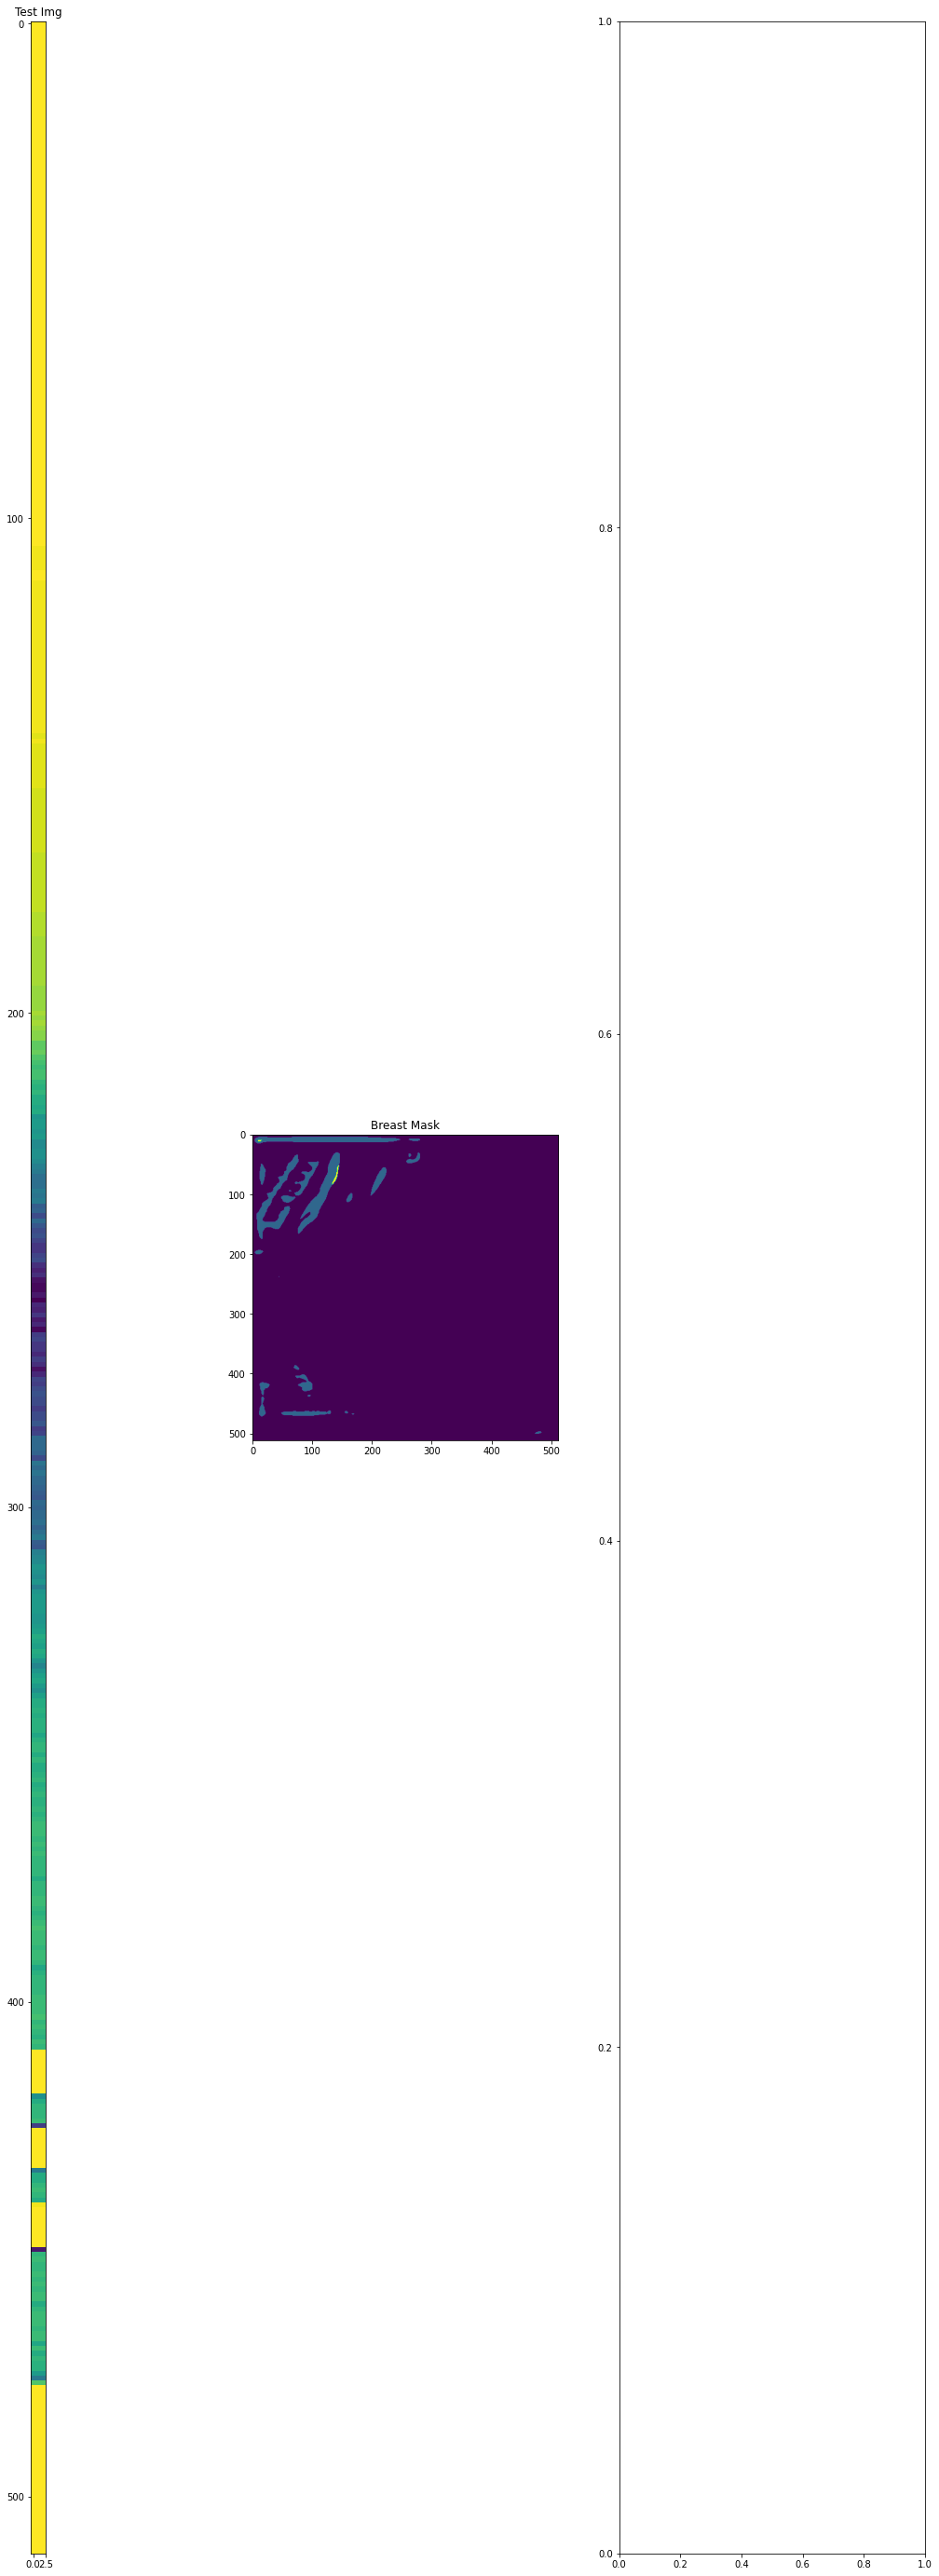

In [28]:
fig=plt.figure(figsize=(20,50))
rows = 1
columns = 3
fig.add_subplot(rows, columns, 1)
plt.imshow(test_img[0] )
plt.title("Test Img")
fig.add_subplot(rows, columns, 2)
plt.imshow( prediction_image)
plt.title("Breast Mask")
fig.show()
fig.add_subplot(rows, columns, 3)
plt.imshow( cropped)
plt.title("Cropped image")
fig.show()

In [ ]:
# Remove background using bitwise-and operation
result = cv2.bitwise_and(image, image, mask=mask)
# result[thresh==0] = [255,255,255] # Turn background white

# plt.imshow( thresh)
# plt.show()
plt.imshow( result)
plt.show()